In [3]:
# Install Keras (if not already installed)
!pip install keras

# Install scikit-learn (if not already installed)
!pip install scikit-learn

# Install nltk
!pip install nltk

# Install BeautifulSoup
!pip install beautifulsoup4

# Install plotly
!pip install plotly

# Install cufflinks
!pip install cufflinks



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00


In [5]:
!pip install tensorflow


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
!pip install chart-studio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 6.2 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

init_notebook_mode(connected=True)
cf.go_offline()
#import plotly.graph_objs as go
from chart_studio import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/26k-consumer-complaints.csv')


In [12]:
df.head()


,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,Navy FCU,In progress,Yes,NaN
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,Transworld Systems Inc.,In progress,Yes,NaN


In [13]:
df.Product.value_counts()

,count
Product,
Debt collection,7494
Mortgage,6612
Credit reporting,5717
Credit card,2830
Bank account or service,2609
Consumer loan,1314
Student loan,785
Payday loan,348
Money transfers,232


In [14]:

df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

<Axes: title={'center': 'Number complaints in each product'}, xlabel='Product'>

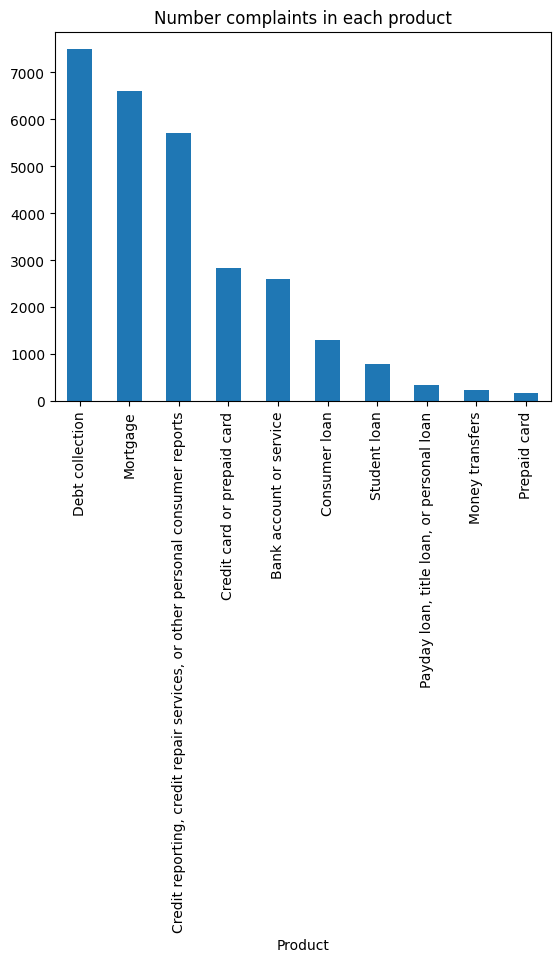

In [15]:
df['Product'].value_counts().sort_values(ascending=False).plot(kind='bar',
                                                                title='Number complaints in each product')


In [16]:
def print_plot(index):
    example = df[df.index == index][['Issue', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [17]:

print_plot(10)

False statements or representation
Product: Debt collection


In [18]:
print_plot(100)

Communication tactics
Product: Debt collection


In [19]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Issue'] = df['Issue'].apply(clean_text)

In [20]:

df['Issue'] = df['Issue'].str.replace('\d+', '')

In [21]:
print_plot(10)

false statements representation
Product: Debt collection


In [22]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Issue'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 161 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(df['Issue'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (28116, 250)


In [24]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (28116, 10)


In [26]:
from sklearn.model_selection import train_test_split


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(25304, 250) (25304, 10)
(2812, 250) (2812, 10)


In [28]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
epochs = 3
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 524ms/step - accuracy: 0.6137 - loss: 1.4045 - val_accuracy: 0.9644 - val_loss: 0.1627
Epoch 2/3
89/89 ━━━━━━━━━━━━━━━━━━━━ 68s 437ms/step - accuracy: 0.9740 - loss: 0.1162 - val_accuracy: 0.9937 - val_loss: 0.0486
Epoch 3/3
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - accuracy: 0.9926 - loss: 0.0403 - val_accuracy: 0.9949 - val_loss: 0.0266


In [32]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9948 - loss: 0.0245
Test set
  Loss: 0.026
  Accuracy: 0.994


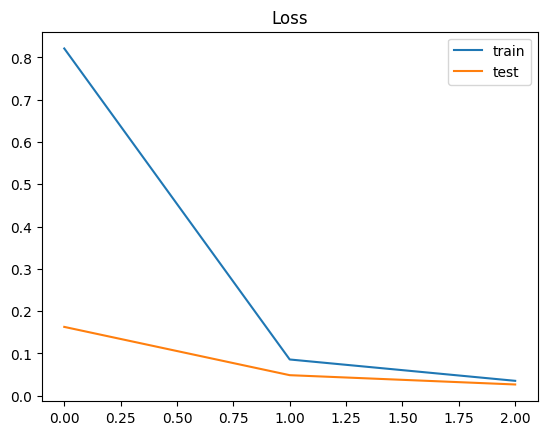

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

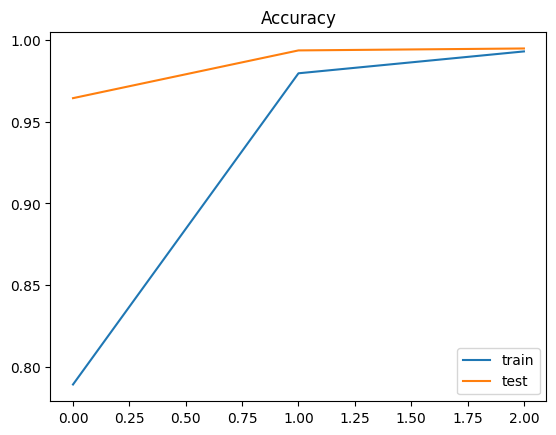

In [30]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [33]:

new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, "\n" ,labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
[[1.4924192e-03 2.8180541e-03 6.2295675e-02 8.8225347e-01 4.9957848e-04
  2.1261829e-03 4.4057533e-02 7.6059421e-04 3.4566678e-03 2.3985931e-04]] 
 Credit card or prepaid card
